In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib

In [2]:
# Load data
df = pd.read_csv("monthly_milk_production.csv", index_col='Date', parse_dates=True)
print(df.head())
print(df.info())

            Production
Date                  
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB
None


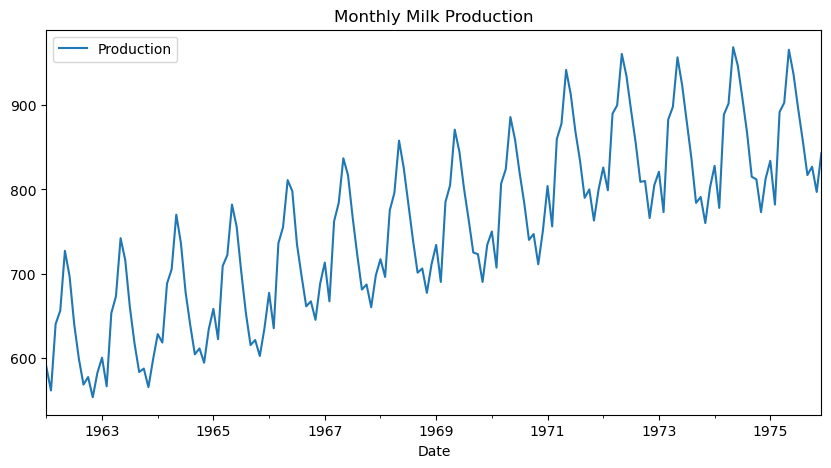

In [3]:
# Plot original series
df.plot(figsize=(10, 5), title='Monthly Milk Production')
plt.show()

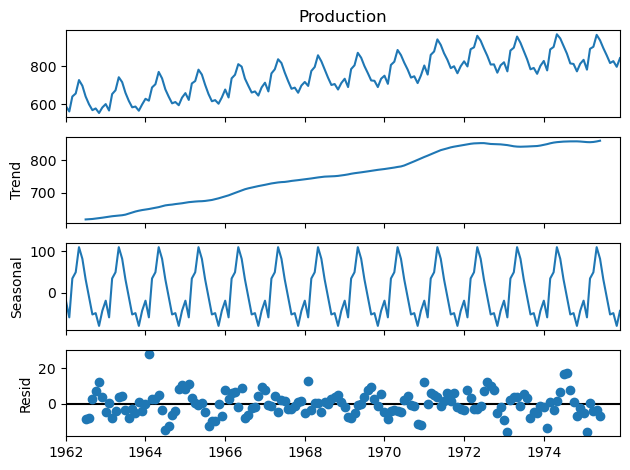

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Seasonal Decomposition
decomp = seasonal_decompose(df['Production'], model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()

In [4]:
# Split data into train and test (80/20 split)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [5]:
# Scale data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [6]:
n_input = 12
n_features = 1

# Prepare generator for training
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mse')

# Train model
history = model.fit(train_generator, epochs=100, batch_size=1, verbose=0)

C:\Users\user\.anaconda\3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\user\.anaconda\3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0760
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0258
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0204
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0191
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0245
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0120
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0061
Epoch 8/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0124
Epoch 9/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0051
Epoch 10/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0046
Epoch 11/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0048
Epoch 12/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0057
Epoch 13/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0034
Epoch 14/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0035
Epoch 15/100
122/122 ━━━━━━━

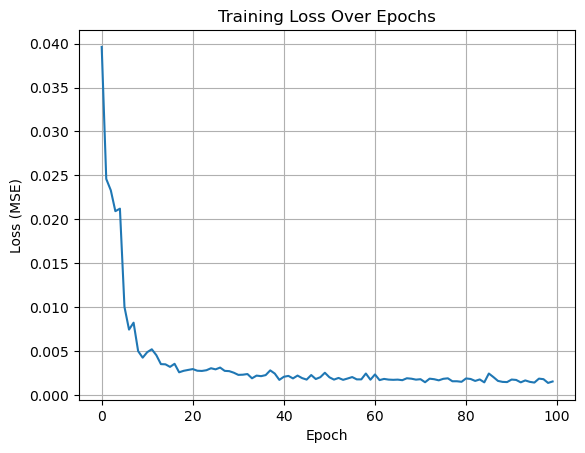

In [8]:
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

In [9]:
# Prepare for prediction on train data (for in-sample evaluation)
predicted_scaled = model.predict(train_generator)
predicted = scaler.inverse_transform(predicted_scaled)

# True values for training (skipping initial n_input to align)
true_scaled = scaled_train[n_input:]
true = scaler.inverse_transform(true_scaled)

122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


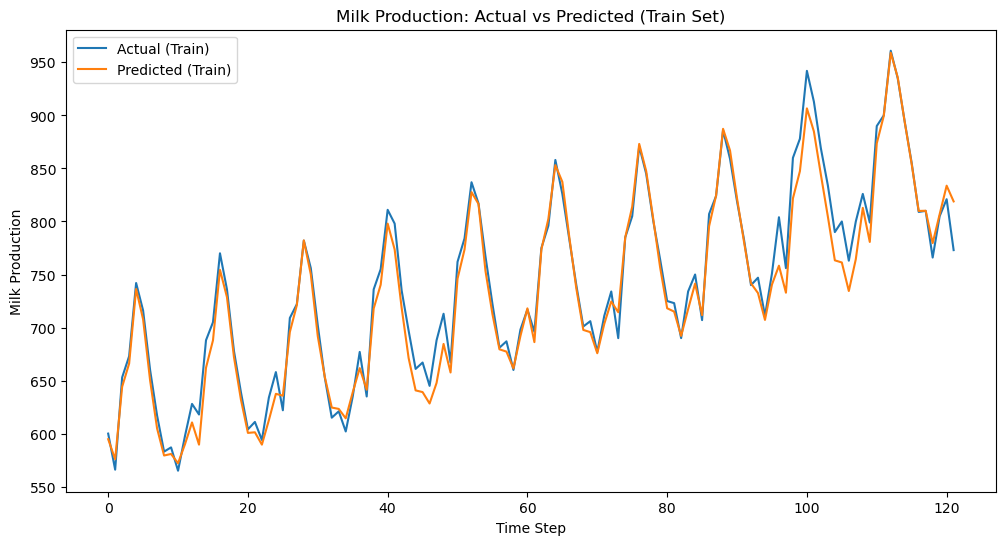

In [10]:
# Plot actual vs predicted on training set
plt.figure(figsize=(12, 6))
plt.plot(true, label='Actual (Train)')
plt.plot(predicted, label='Predicted (Train)')
plt.title("Milk Production: Actual vs Predicted (Train Set)")
plt.xlabel("Time Step")
plt.ylabel("Milk Production")
plt.legend()
plt.show()

In [11]:
# Forecasting future (test period) step-by-step
forecast_steps = len(test)
# Use last n_input points from training data to start forecasting
current_batch = scaled_train[-n_input:].reshape((1, n_input, n_features))
forecast_predictions = []

for _ in range(forecast_steps):
    pred = model.predict(current_batch)[0]
    forecast_predictions.append(pred)
    # Update current_batch with prediction for next step
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

# Inverse scale forecast predictions
forecast_predictions = scaler.inverse_transform(np.array(forecast_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
# Add predictions to test dataframe
test = test.copy()
test['Predictions'] = forecast_predictions.flatten()

# Evaluate on test set
rmse = sqrt(mean_squared_error(test['Production'], test['Predictions']))
mae = mean_absolute_error(test['Production'], test['Predictions'])
relative_rmse = rmse / test['Production'].mean()

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Relative RMSE: {relative_rmse:.2%}")

Test RMSE: 36.41
Test MAE: 31.74
Relative RMSE: 4.24%


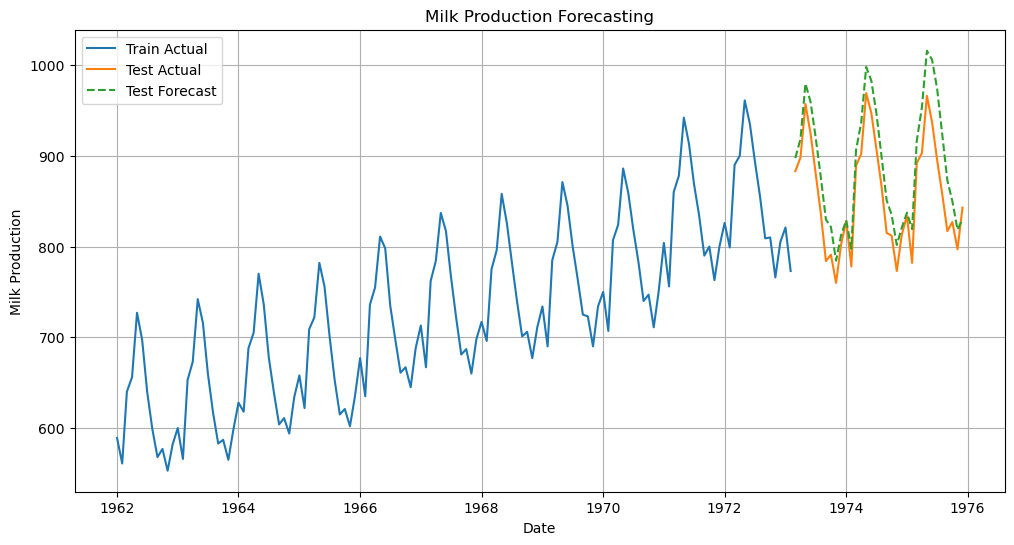

In [13]:
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Production'], label='Train Actual')
plt.plot(test.index, test['Production'], label='Test Actual')
plt.plot(test.index, test['Predictions'], label='Test Forecast', linestyle='--')
plt.title('Milk Production Forecasting')
plt.xlabel('Date')
plt.ylabel('Milk Production')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
test['Predictions'] = forecast_predictions

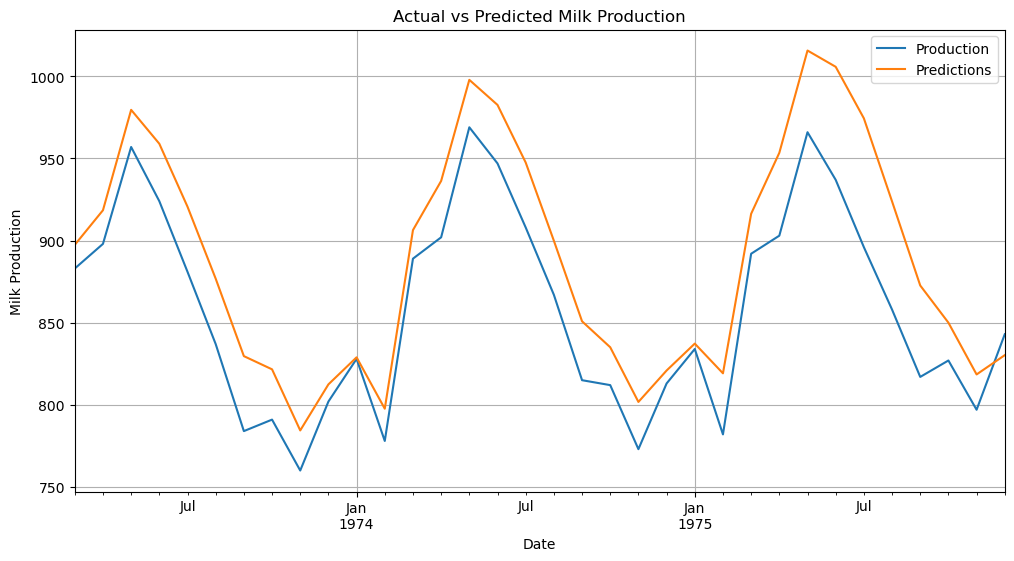

In [18]:
# Plot Actual vs Predicted Milk Production
test.plot(figsize=(12, 6), title='Actual vs Predicted Milk Production')
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.grid(True)
plt.show()

In [20]:
forecast_flat = forecast_predictions.flatten()
# Add predictions to test DataFrame
test = test.copy()  # to avoid SettingWithCopyWarning
test['Predictions'] = forecast_flat[:len(test)]

RMSE: 36.41


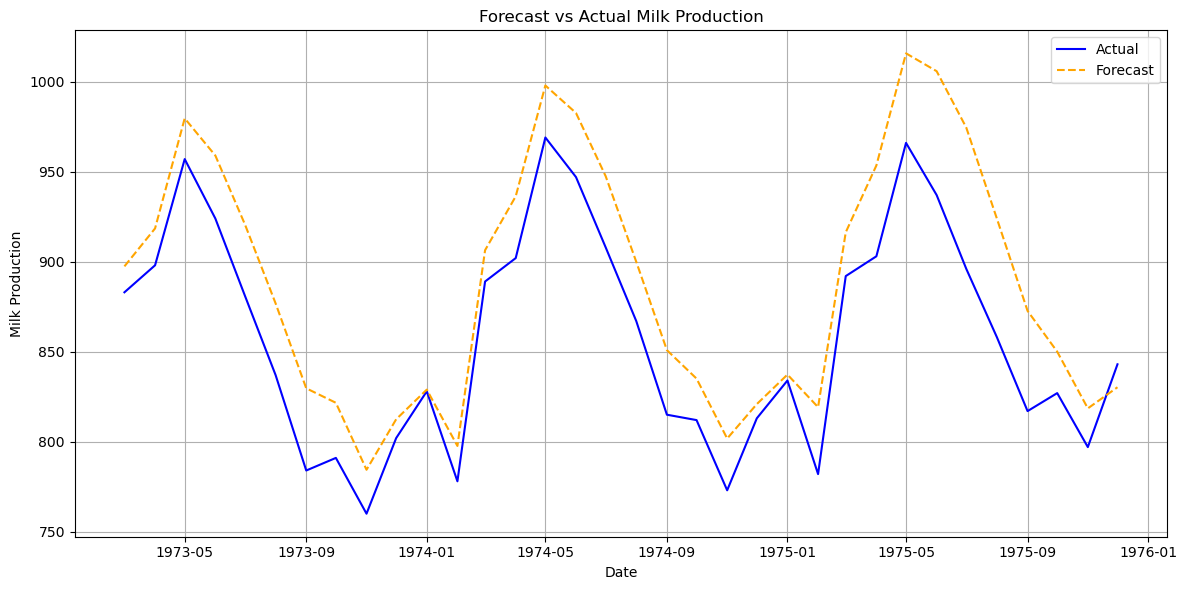

In [21]:
# Compute RMSE
rmse = sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(f"RMSE: {rmse:.2f}")

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Production'], label='Actual', color='blue')
plt.plot(test.index, test['Predictions'], label='Forecast', color='orange', linestyle='--')
plt.title("Forecast vs Actual Milk Production")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Save model and scaler
model.save("milk1_lstm_model.h5")
joblib.dump(scaler, "scaler.save1")
print("Model and scaler saved.")

Model and scaler saved.
